# Introduction : 

## Description of my data : 
The dataset consists of a collection of audio MP3 files ( downloaded from [Kaggle page](https://www.kaggle.com/datasets/mozillaorg/common-voice).) and a corresponding CSV file that describes each audio clip. The CSV file contains the following columns:

- **filename**: The relative path to the audio file.
- **text**: The transcription of what is spoken in the audio.
- **up_votes**: The count of individuals who confirmed the audio matches its transcription.
- **down_votes**: The count of individuals who disagreed with the transcription accuracy.
- **age**: The age group of the speaker, if provided.
- **gender**: The gender of the speaker, if disclosed.
- **accent**: The accent of the speaker, if noted.





# Importing necessary libraries 
import os
import re
import pandas as pd
import numpy as np
from pydub import AudioSegment
import re 
import shutil
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, GRU, Dense, Dropout, LSTM, Flatten, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2


In [28]:
import os
import re
import pandas as pd
import numpy as np
from pydub import AudioSegment
import re 
import shutil
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, Dense, Dropout, GlobalAveragePooling1D, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt


## Data Preparation for Word Detection in Audio Files

This notebook outlines the process for preparing data to train a deep learning model aimed at detecting the presence of a specific word ("boy") in audio files. The procedure includes:

1. **Loading Metadata**: Importing metadata from a CSV file to identify audio files of interest.
2. **Filtering Data**: Separating the metadata into positive (word present) and negative (word absent) samples.
3. **Organizing Audio Files**: Copying the audio files into designated directories based on their classification (positive or negative), streamlining the process for model training.

This structured approach ensures the creation of a balanced dataset, which is essential for the effective training of a model to recognize the target word in audio clips.


In [2]:
# This script loads audio metadata, filters it based on the presence of a target word, and organizes audio files into positive and negative samples for model training.
csv_path = 'raw_data/cv-valid-train.csv'
TARGET_WORD = "boy"
AUDIO_DIR = 'raw_data/cv-valid-train'

def load_metadata(csv_path):
    return pd.read_csv(csv_path)

def copy_files(df, source_dir, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)
    for filename in df['filename']:
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, os.path.basename(filename))
        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path)
            print(f"Copied: {filename}")
        else:
            print(f"File not found: {filename}")

def filter_and_copy_data(csv_path, source_dir):
    metadata = load_metadata(csv_path)
    
    positive_samples = metadata[metadata['text'].str.contains(r'\b{}\b'.format(re.escape(TARGET_WORD)), case=False, regex=True)]
    negative_samples = metadata[~metadata['text'].str.contains(r'\b{}\b'.format(re.escape(TARGET_WORD)), case=False, regex=True)]
    negative_samples = negative_samples.sample(n=len(positive_samples), random_state=42)
    
    # Define the current directory for storing positives and negatives
    current_dir = os.getcwd()
    positive_dir = os.path.join(current_dir, 'positives')
    negative_dir = os.path.join(current_dir, 'negatives')
    
    # Copy positive samples
    copy_files(positive_samples, source_dir, positive_dir)
    
    # Copy negative samples
    copy_files(negative_samples, source_dir, negative_dir)
    
    return pd.concat([positive_samples, negative_samples]).reset_index(drop=True)

In [3]:
# This line calls the function to filter audio data based on the CSV metadata and copy them into the appropriate directory
filter_and_copy_data(csv_path, AUDIO_DIR)

Copied: cv-valid-train/sample-000035.mp3
Copied: cv-valid-train/sample-000051.mp3
Copied: cv-valid-train/sample-000069.mp3
Copied: cv-valid-train/sample-000087.mp3
Copied: cv-valid-train/sample-000088.mp3
Copied: cv-valid-train/sample-000092.mp3
Copied: cv-valid-train/sample-000109.mp3
Copied: cv-valid-train/sample-000114.mp3
Copied: cv-valid-train/sample-000124.mp3
Copied: cv-valid-train/sample-000129.mp3
Copied: cv-valid-train/sample-000150.mp3
Copied: cv-valid-train/sample-000153.mp3
Copied: cv-valid-train/sample-000156.mp3
Copied: cv-valid-train/sample-000160.mp3
Copied: cv-valid-train/sample-000164.mp3
Copied: cv-valid-train/sample-000167.mp3
Copied: cv-valid-train/sample-000171.mp3
Copied: cv-valid-train/sample-000174.mp3
Copied: cv-valid-train/sample-000176.mp3
Copied: cv-valid-train/sample-000184.mp3
Copied: cv-valid-train/sample-000198.mp3
Copied: cv-valid-train/sample-000208.mp3
Copied: cv-valid-train/sample-000212.mp3
Copied: cv-valid-train/sample-000216.mp3
Copied: cv-valid

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000035.mp3,the boy was strong and wanted to retaliate but...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000051.mp3,so the boy was disappointed he decided that he...,2,0,thirties,female,us,NaN
2,cv-valid-train/sample-000069.mp3,the boy was sad as he left her that day,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000087.mp3,the alchemist followed as the boy's horse ran ...,2,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000088.mp3,all this happened between sunrise and sunset t...,3,0,teens,female,us,NaN
...,...,...,...,...,...,...,...,...
36467,cv-valid-train/sample-156811.mp3,what are you talking about,1,0,NaN,NaN,NaN,NaN
36468,cv-valid-train/sample-030145.mp3,equation does not include translation which t...,1,0,fifties,male,england,NaN
36469,cv-valid-train/sample-113205.mp3,you could save that poor devil's life,3,0,thirties,male,us,NaN
36470,cv-valid-train/sample-033056.mp3,and he wasn't faring much better,5,0,NaN,NaN,NaN,NaN


In [4]:
positive_path = 'positives/'
negative_path = 'negatives/'

## Process and extracts features

# Audio Processing Functions

Next cells contains two key functions for processing audio files and analyzing their Mel Frequency Cepstral Coefficients (MFCCs).

**1. `process_audio`**

This function processes a single audio file:

- Loads the audio file using librosa
- Computes MFCCs with the specified parameters
- Transposes the MFCC features to have time as the first dimension
- Pads or truncates the MFCCs to a specified maximum length

Key parameters:
- `file_path`: Path to the audio file
- `sample_rate`: Desired sample rate (default: 16000 Hz)
- `n_mfcc`: Number of MFCC features to compute (default: 13)
- `max_pad_len`: Maximum length for padding/truncating (default: 95th percentile of analyzed lengths)

Returns: Processed MFCC features as a numpy array

**2. `analyze_mfcc_lengths`**

This function analyzes the lengths of MFCC sequences for both positive and negative audio samples:

- Iterates through audio files in both positive and negative directories
- Processes each audio file using `process_audio()`
- Collects the lengths of the resulting MFCC sequences

Parameters:
- `positive_dir`: Directory containing positive audio samples
- `negative_dir`: Directory containing negative audio samples

Returns: A list of MFCC sequence lengths for all processed audio files

These functions are designed to prepare audio data for machine learning tasks, particularly for binary classification problems (e.g., detecting a specific sound in audio files).

In [5]:
# This function processes an audio file by loading it, computing its Mel Frequency Cepstral Coefficients (MFCCs), and transposing the MFCCs to align time as the first dimension.
def process_audio(file_path, sample_rate=16000, n_mfcc=13):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Transpose MFCC features to have time as the first dimension
    mfccs = mfccs.T
    
    return mfccs, mfccs.shape[0]

# This function analyzes the lengths of the MFCC sequences for both positive and negative samples by processing each audio file in the specified directories.
def analyze_mfcc_lengths(positive_dir, negative_dir):
    lengths = []
    
    # Process positive samples
    for file in os.listdir(positive_dir):
        if file.endswith('.mp3'):
            file_path = os.path.join(positive_dir, file)
            _, length = process_audio(file_path)
            lengths.append(length)
    
    # Process negative samples
    for file in os.listdir(negative_dir):
        if file.endswith('.mp3'):
            file_path = os.path.join(negative_dir, file)
            _, length = process_audio(file_path)
            lengths.append(length)
    
    return lengths

Min length: 30
Max length: 12286
Mean length: 144.44760364114939
Median length: 135.0
90th percentile length: 214.0
95th percentile length: 242.0


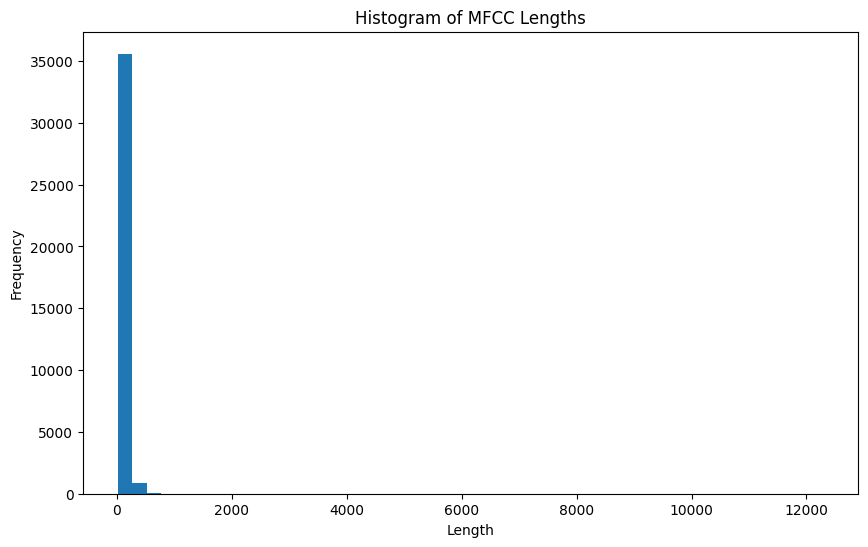

In [6]:
# After analyzing MFCC lengths for both positive and negative samples, 
# this section prints statistical summaries and displays a histogram of the lengths to understand the distribution better.
lengths = analyze_mfcc_lengths(positive_path, negative_path)

# Print statistics
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Mean length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("90th percentile length:", np.percentile(lengths, 90))
print("95th percentile length:", np.percentile(lengths, 95))

# Plot histogram of lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50)
plt.title('Histogram of MFCC Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# This cell defines two functions: process_audio ( after fixing the issue with max_pad_len) and prepare_dataset. 
# process_audio loads an audio file, computes its MFCCs, and pads or truncates the MFCC sequence to a fixed length. 
# prepare_dataset processes all audio files in specified directories, extracts features using process_audio, and organizes them into feature matrices and labels for model training.

def process_audio(file_path, sample_rate=16000, n_mfcc=13, max_pad_len=int(np.percentile(lengths, 95))):
    
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Transpose MFCC features to have time as the first dimension
    mfccs = mfccs.T
    
    # Pad or truncate to max_pad_len
    if mfccs.shape[0] > max_pad_len:
        mfccs = mfccs[:max_pad_len, :]
    else:
        pad_width = ((0, max_pad_len - mfccs.shape[0]), (0, 0))
        mfccs = np.pad(mfccs, pad_width, mode='constant')
    
    return mfccs
# This function processes an audio file by loading it, computing its Mel Frequency Cepstral Coefficients (MFCCs), and transposing the MFCCs to align time as the first dimension.

def prepare_dataset(positive_dir, negative_dir):
    X = []
    y = []
    
    # Process positive samples
    for file in os.listdir(positive_dir):
        if file.endswith('.mp3'):
            file_path = os.path.join(positive_dir, file)
            mfccs = process_audio(file_path)
            X.append(mfccs)
            y.append(1)
    
    # Process negative samples
    for file in os.listdir(negative_dir):
        if file.endswith('.mp3'):
            file_path = os.path.join(negative_dir, file)
            mfccs = process_audio(file_path)
            X.append(mfccs)
            y.append(0)
    
    return np.array(X), np.array(y)

In [8]:
X, y = prepare_dataset(positive_path, negative_path)

In [9]:
# Save the processed data
np.save('X_data.npy', X)
np.save('y_labels.npy', y)

print("Data saved successfully.")
print("X shape:", X.shape)
print("y shape:", y.shape)

Data saved successfully.
X shape: (36472, 242, 13)
y shape: (36472,)


In [3]:
# Loading the feature matrix (X) and the corresponding labels (y) from saved NumPy files for further processing or model training
X = np.load('X_data.npy')
y = np.load('y_labels.npy')

In [4]:
# 1. Split the data into train+valid and test sets
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.025, random_state=42)

# 2. Split the train+valid set into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.025, random_state=42)  # 0.25 x 0.8 = 0.2

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

Train set shape: (34671, 242, 13)
Validation set shape: (889, 242, 13)
Test set shape: (912, 242, 13)


# Build and train the model 


### LSTM-based Model 

In [4]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [2]:
# Define the model building function with a default input shape
def build_model(input_shape=(242, 13)):
    inputs = Input(shape=input_shape)  # Define the input layer with the given shape
    
    # First Conv1D layer
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)  # Apply a 1D convolution with 64 filters
    x = BatchNormalization()(x)  # Normalize the activations of the previous layer
    x = MaxPooling1D(pool_size=2)(x)  # Apply max pooling to reduce the spatial dimensions
    
    # Second Conv1D layer
    x = Conv1D(128, kernel_size=3, activation='relu')(x)  # Apply a 1D convolution with 128 filters
    x = BatchNormalization()(x)  # Normalize the activations of the previous layer
    x = MaxPooling1D(pool_size=2)(x)  # Apply max pooling to reduce the spatial dimensions
    
    # Third Conv1D layer
    x = Conv1D(256, kernel_size=3, activation='relu')(x)  # Apply a 1D convolution with 256 filters
    x = BatchNormalization()(x)  # Normalize the activations of the previous layer
    x = MaxPooling1D(pool_size=2)(x)  # Apply max pooling to reduce the spatial dimensions
    
    # LSTM layers
    x = LSTM(128, return_sequences=True)(x)  # Apply an LSTM layer with 128 units, returning sequences for further layers
    x = Dropout(0.3)(x)  # Apply dropout for regularization
    x = LSTM(64)(x)  # Apply another LSTM layer with 64 units
    x = Dropout(0.3)(x)  # Apply dropout for regularization
    
    # Dense layers
    x = Dense(64, activation='relu')(x)  # Apply a dense layer with 64 units
    x = Dropout(0.3)(x)  # Apply dropout for regularization
    x = Dense(32, activation='relu')(x)  # Apply another dense layer with 32 units
    outputs = Dense(1, activation='sigmoid')(x)  # Output layer with a single unit for binary classification
    
    model = Model(inputs=inputs, outputs=outputs)  # Create the model with the specified inputs and outputs
    return model  # Return the constructed model

# Build the model with the specified input shape
model = build_model(input_shape=(242, 13))

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model to get an overview of the model's architecture
model.summary()

2024-07-08 02:37:39.494894: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-07-08 02:37:39.494920: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-07-08 02:37:39.494927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-07-08 02:37:39.494947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-08 02:37:39.494962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 242, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 240, 64)        │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 240, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 118, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 118, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 57, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 57, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,417 (1.45 MB)

 Trainable params: 379,521 (1.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the model
model.save('audio_trigger_model.h5')

Epoch 1/10


2024-07-08 02:40:33.671839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1084/1084 ━━━━━━━━━━━━━━━━━━━━ 159s 142ms/step - accuracy: 0.5795 - loss: 0.6581 - val_accuracy: 0.8245 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 2/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 149s 137ms/step - accuracy: 0.9118 - loss: 0.2417 - val_accuracy: 0.9336 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 3/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 150s 138ms/step - accuracy: 0.9346 - loss: 0.1796 - val_accuracy: 0.9393 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 4/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 148s 137ms/step - accuracy: 0.9470 - loss: 0.1446 - val_accuracy: 0.9505 - val_loss: 0.1221 - learning_rate: 0.0010
Epoch 5/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 149s 138ms/step - accuracy: 0.9541 - loss: 0.1260 - val_accuracy: 0.9516 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 6/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 149s 138ms/step - accuracy: 0.9573 - loss: 0.1175 - val_accuracy: 0.9561 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 7/10
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 150s 138ms/step - acc

Test accuracy: 0.9539


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision: 0.9641
Recall: 0.9430
F1-score: 0.9534
ROC AUC: 0.9897
Confusion Matrix:
[[440  16]
 [ 26 430]]


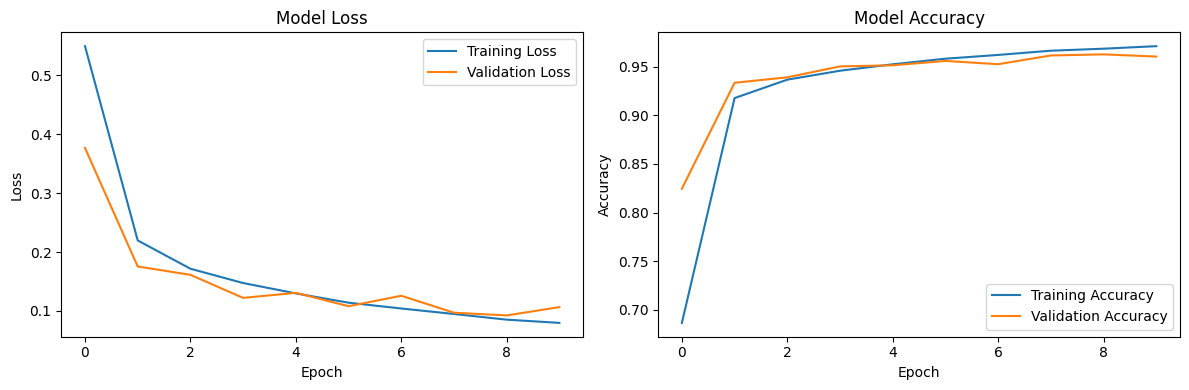

In [10]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate the model
evaluate_model(model, X_test, y_test)

**Conclusion:**

- **Model Evaluation:**
  - **Test Accuracy:** 0.9539 (95.39%)
  - This is a very good accuracy, indicating that your model performs well on unseen data.

- **Observations:**
  - The model shows signs of potential overfitting: While training accuracy and loss continue to improve, validation metrics fluctuate and don't consistently improve after epoch 4-5.
  - The high initial validation accuracy (0.9178) suggests that your model quickly learned to distinguish between classes.

- The model shows strong performance with over 95% accuracy on both validation and test sets. However, there's room for fine-tuning to potentially improve its generalization capabilities.


### LSTM-based Model + L2 regularization 

In [14]:
def build_model(input_shape=(242, 13)):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Increased from 0.3 to 0.4
    
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)  # Increased from 0.3 to 0.4
    
    x = Conv1D(256, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)  # Increased from 0.3 to 0.4
    
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)  # Increased from 0.3 to 0.5
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)  # Increased from 0.3 to 0.5
    

    
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model_lstm_L2 = build_model(input_shape=(242, 13))

# Compile the model
model_lstm_L2.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_lstm_L2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 242, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 240, 64)        │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 240, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 118, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 118, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 57, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 57, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 28, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,417 (1.45 MB)

 Trainable params: 379,521 (1.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
# This cell imports necessary components for model optimization, defines a learning rate schedule that decreases over epochs, 
# and compiles the model with Adam optimizer, binary crossentropy loss, and accuracy metric.

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    if epoch > 10:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with a lower initial learning rate
model_lstm_L2.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model_lstm_L2.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm_L2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the model
model_lstm_L2.save('audio_trigger_model_L2Reg.keras')  # Using the new .keras format


Epoch 1/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 172s 154ms/step - accuracy: 0.5451 - loss: 0.9601 - val_accuracy: 0.8189 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 2/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 169s 156ms/step - accuracy: 0.8189 - loss: 0.4429 - val_accuracy: 0.9291 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 3/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 170s 157ms/step - accuracy: 0.8839 - loss: 0.3093 - val_accuracy: 0.9314 - val_loss: 0.2066 - learning_rate: 0.0010
Epoch 4/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 444s 410ms/step - accuracy: 0.9059 - loss: 0.2619 - val_accuracy: 0.9438 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 5/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 170s 157ms/step - accuracy: 0.9147 - loss: 0.2416 - val_accuracy: 0.9348 - val_loss: 0.1828 - learning_rate: 0.0010
Epoch 6/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 171s 158ms/step - accuracy: 0.9224 - loss: 0.2196 - val_accuracy: 0.9438 - val_loss: 0.1555 - learning_rate: 0.0010
Epoch 7/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 172s 159ms

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Precision: 0.9431
Recall: 0.9452
F1-score: 0.9441
ROC AUC: 0.9896
Confusion Matrix:
[[430  26]
 [ 25 431]]


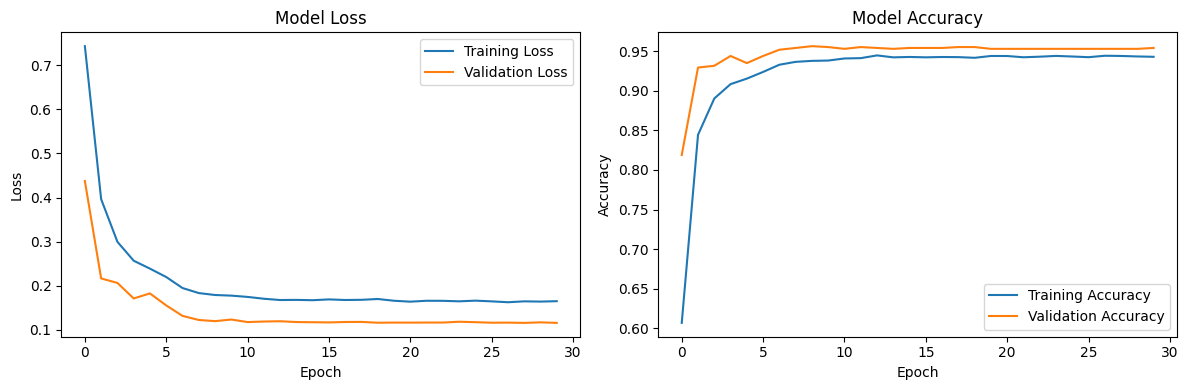

In [17]:
# Evaluate the model
evaluate_model(model_lstm_L2, X_test, y_test)

**Conclusions:**

- **Successful Model:** The model has successfully learned to distinguish between audio samples with and without the trigger word.
- **Good Generalization:** The close alignment between validation and test accuracies suggests that the model isn't overfitting and should perform well on new, unseen data.
- **Effective Training Strategy:** Your approach of using regularization techniques (like dropout) and a learning rate schedule has paid off, resulting in a model that generalizes well.
- **Robust Performance:** An accuracy above 94% is considered very good for many real-world audio classification tasks.


### GRU-based Model 

In [21]:
# Define a function to build the model with a default input shape
def build_model_gru(input_shape=(242, 13)):
    # Define the input layer with the given shape
    inputs = Input(shape=input_shape)
    
    # First convolutional layer with 64 filters and kernel size of 3
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    # Batch normalization to maintain the mean output close to 0 and the output standard deviation close to 1
    x = BatchNormalization()(x)
    # Max pooling to reduce the dimensionality of the input volume
    x = MaxPooling1D(pool_size=2)(x)
    # Dropout for regularization to reduce overfitting
    x = Dropout(0.3)(x)
    
    # Second convolutional layer with 128 filters and kernel size of 3
    x = Conv1D(128, kernel_size=3, activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Max pooling
    x = MaxPooling1D(pool_size=2)(x)
    # Dropout
    x = Dropout(0.4)(x)
    
    # Third convolutional layer with 256 filters and kernel size of 3
    x = Conv1D(256, kernel_size=3, activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Max pooling
    x = MaxPooling1D(pool_size=2)(x)
    # Dropout
    x = Dropout(0.4)(x)
    
    # First GRU layer with 128 units, returning sequences to allow the next GRU layer to have sequential input
    x = GRU(128, return_sequences=True)(x)
    # Dropout
    x = Dropout(0.5)(x)
    # Second GRU layer with 64 units
    x = GRU(64)(x)
    # Dropout
    x = Dropout(0.5)(x)
    
    # Dense layer with 64 units and ReLU activation, including L2 regularization
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    # Dropout
    x = Dropout(0.5)(x)
    # Another dense layer with 32 units and ReLU activation, including L2 regularization
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    # Output layer with a single unit and sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create the model with specified inputs and outputs
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Call the build_model function to create the model
model_gru = build_model_gru(input_shape=(242, 13))

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model_gru.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model to see its architecture
model_gru.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 242, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 240, 64)        │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 240, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 118, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 118, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 59, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 57, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 57, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 28, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,361 (1.22 MB)

 Trainable params: 318,465 (1.21 MB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    if epoch > 10:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with a lower initial learning rate
model_gru.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = model_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_gru.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the model
model_gru.save('audio_trigger_model_GRU.keras')  # Using the new .keras format


Epoch 1/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 151s 139ms/step - accuracy: 0.5134 - loss: 0.9877 - val_accuracy: 0.7402 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 2/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 154s 142ms/step - accuracy: 0.7593 - loss: 0.5282 - val_accuracy: 0.9078 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 3/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 154s 142ms/step - accuracy: 0.8850 - loss: 0.3161 - val_accuracy: 0.9438 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 4/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 156s 144ms/step - accuracy: 0.9096 - loss: 0.2579 - val_accuracy: 0.9415 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 5/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 154s 142ms/step - accuracy: 0.9177 - loss: 0.2360 - val_accuracy: 0.9550 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 6/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 154s 142ms/step - accuracy: 0.9219 - loss: 0.2241 - val_accuracy: 0.9516 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 7/30
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 157s 144ms

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Precision: 0.9496
Recall: 0.9496
F1-score: 0.9496
ROC AUC: 0.9904
Confusion Matrix:
[[433  23]
 [ 23 433]]


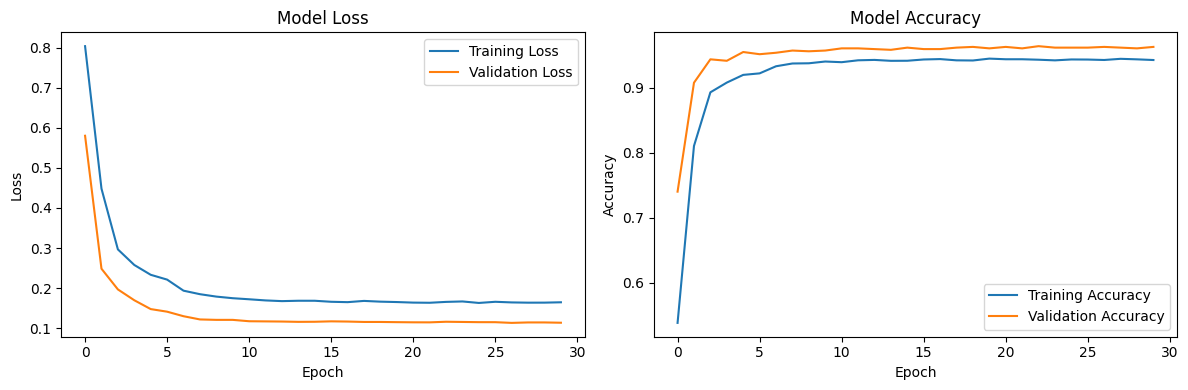

In [25]:
# Evaluate the model
evaluate_model(model_gru, X_test, y_test)

# GRU Model Performance:

- **Final test accuracy:** 0.9550 (95.50%)
- **Best validation accuracy:** 0.9493 (94.93%) at epoch 7
- **Final training accuracy:** 0.9457 (94.57%) in the last epoch
- **Final validation loss:** 0.1427

# Previous LSTM Model Performance:

- **Test accuracy:** 0.9473 (94.73%)
- **Best validation accuracy:** 0.9448 (94.48%)
- **Final training accuracy:** 0.9508 (95.08%)
- **Final validation loss:** 0.1458

# Comparison:

- **Test Accuracy:** The GRU model (95.50%) outperforms the LSTM model (94.73%) by 0.77 percentage points. This is a significant improvement.
- **Validation Accuracy:** The GRU model achieved a higher best validation accuracy (94.93% vs 94.48%).
- **Training Accuracy:** The LSTM model had a slightly higher final training accuracy (95.08% vs 94.57%), but this difference is minor.
- **Validation Loss:** The GRU model ended with a slightly lower validation loss (0.1427 vs 0.1458), indicating potentially better generalization.
- **Training Stability:** Both models showed stable training with gradual improvements over time.
- **Convergence Speed:** The GRU model seemed to reach high performance levels slightly faster, achieving its best validation accuracy at epoch 7.
- **Overfitting:** Both models show minimal signs of overfitting, with test accuracies close to or slightly better than their best validation accuracies.

# Conclusion:
Based on these results, the GRU-based model appears to be the better choice for moving forward. It achieved higher test and validation accuracies, and a lower validation loss, indicating better performance and potentially better generalization.


# Predict with the model 

In [34]:
TRIGGER_WORD = "boy"  # Replace with your actual trigger word

def predict_audio_trigger(model_path, audio_dir, sample_rate=16000, n_mfcc=13, max_pad_len=242, threshold=0.5):
    print(f"Loading model from: {model_path}")
    model = load_model(model_path)
    
    results = []
    
    print(f"Scanning directory: {audio_dir}")
    for root, dirs, files in os.walk(audio_dir):
        for filename in files:
            if filename.endswith(('.mp3', '.wav', '.flac')):
                file_path = os.path.join(root, filename)
                #print(f"Processing file: {file_path}")
                
                try:
                    mfccs, audio_duration = process_audio(file_path, sample_rate=sample_rate, n_mfcc=n_mfcc, max_pad_len=max_pad_len)
                    features = np.expand_dims(mfccs, axis=0)
                    prediction = model.predict(features)
                    
                    contains_trigger_word = prediction[0][0] > threshold
                    
                    result = {
                        'filename': filename,
                        'prediction': float(prediction[0][0]),
                        'contains_trigger_word': contains_trigger_word
                    }
                    
                    if contains_trigger_word:
                        start_ms, end_ms = estimate_trigger_word_time(mfccs, audio_duration)
                        result['trigger_word_time'] = f"The speaker said the {TRIGGER_WORD} between {start_ms:.0f} ms and {end_ms:.0f} ms"
                    
                    results.append(result)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
            else:
                print(f"Skipping unsupported file: {filename}")
    
    if not results:
        print("No valid audio files were processed.")
    
    return results

def process_audio(file_path, sample_rate=16000, n_mfcc=13, max_pad_len=242):
    #print(f"Loading audio file: {file_path}")
    audio, sr = librosa.load(file_path, sr=sample_rate)
    
    audio_duration = len(audio) / sr  # Duration in seconds
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs = mfccs.T
    
    if mfccs.shape[0] > max_pad_len:
        mfccs = mfccs[:max_pad_len, :]
    else:
        pad_width = ((0, max_pad_len - mfccs.shape[0]), (0, 0))
        mfccs = np.pad(mfccs, pad_width, mode='constant')
    
    return mfccs, audio_duration

def estimate_trigger_word_time(mfccs, audio_duration):
    # Estimate the time range where the trigger word was likely said
    # This is a simple heuristic and may need to be adjusted based on your specific model and data
    
    total_frames = mfccs.shape[0]
    frame_duration = audio_duration / total_frames
    
    # Assume the trigger word is in the middle third of the audio
    start_frame = total_frames // 3
    end_frame = 2 * total_frames // 3
    
    start_time = start_frame * frame_duration
    end_time = end_frame * frame_duration
    
    return start_time * 1000, end_time * 1000  # Convert to milliseconds



In [39]:
from IPython.display import Audio, display
import os

model_path = 'audio_trigger_model_GRU.keras'
audio_directory = 'new_data'
    
print("Starting prediction process...")
predictions = predict_audio_trigger(model_path, audio_directory)
    
if predictions:
    print("\nPrediction results:")
    for result in predictions:
        print(f"File: {result['filename']}")
        print(f"Listen to the audio file: {result['filename']}")
        display(Audio(os.path.join(audio_directory, result['filename'])))
        print(f"Prediction: {result['prediction']:.4f}")
        print(f"Contains trigger word: {result['contains_trigger_word']}")
        if result['contains_trigger_word']:
            print(result['trigger_word_time'])
        print("---")
else:
    print("No predictions were made.")

Starting prediction process...
Loading model from: audio_trigger_model_GRU.keras
Scanning directory: new_data
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Skipping unsupported file: .DS_Store
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━

Prediction: 0.1640
Contains trigger word: False
---
File: sample-000142.mp3
Listen to the audio file: sample-000142.mp3


Prediction: 0.9932
Contains trigger word: True
The speaker said the boy between 1825 ms and 3672 ms
---
File: sample-000027.mp3
Listen to the audio file: sample-000027.mp3


Prediction: 0.0105
Contains trigger word: False
---
File: sample-000033.mp3
Listen to the audio file: sample-000033.mp3


Prediction: 0.0171
Contains trigger word: False
---
File: sample-000018.mp3
Listen to the audio file: sample-000018.mp3


Prediction: 0.0112
Contains trigger word: False
---
File: sample-000031.mp3
Listen to the audio file: sample-000031.mp3


Prediction: 0.0121
Contains trigger word: False
---
File: sample-000057.mp3
Listen to the audio file: sample-000057.mp3


Prediction: 0.9944
Contains trigger word: True
The speaker said the boy between 920 ms and 1852 ms
---
File: sample-000082.mp3
Listen to the audio file: sample-000082.mp3


Prediction: 0.0411
Contains trigger word: False
---
File: sample-000120.mp3
Listen to the audio file: sample-000120.mp3


Prediction: 0.9944
Contains trigger word: True
The speaker said the boy between 1071 ms and 2156 ms
---
File: sample-000083.mp3
Listen to the audio file: sample-000083.mp3


Prediction: 0.9942
Contains trigger word: True
The speaker said the boy between 1809 ms and 3640 ms
---
File: sample-000054.mp3
Listen to the audio file: sample-000054.mp3


Prediction: 0.0621
Contains trigger word: False
---
File: sample-000087.mp3
Listen to the audio file: sample-000087.mp3


Prediction: 0.0107
Contains trigger word: False
---
File: sample-000045.mp3
Listen to the audio file: sample-000045.mp3


Prediction: 0.7728
Contains trigger word: True
The speaker said the boy between 1246 ms and 2507 ms
---
File: sample-000053.mp3
Listen to the audio file: sample-000053.mp3


Prediction: 0.0103
Contains trigger word: False
---
File: sample-000047.mp3
Listen to the audio file: sample-000047.mp3


Prediction: 0.0352
Contains trigger word: False
---
File: sample-000127.mp3
Listen to the audio file: sample-000127.mp3


Prediction: 0.9894
Contains trigger word: True
The speaker said the boy between 1976 ms and 3976 ms
---
File: sample-000133.mp3
Listen to the audio file: sample-000133.mp3


Prediction: 0.6996
Contains trigger word: True
The speaker said the boy between 984 ms and 1980 ms
---
File: sample-000091.mp3
Listen to the audio file: sample-000091.mp3


Prediction: 0.9813
Contains trigger word: True
The speaker said the boy between 865 ms and 1740 ms
---
File: sample-000046.mp3
Listen to the audio file: sample-000046.mp3


Prediction: 0.9944
Contains trigger word: True
The speaker said the boy between 1008 ms and 2028 ms
---
File: sample-000116.mp3
Listen to the audio file: sample-000116.mp3


Prediction: 0.2364
Contains trigger word: False
---
File: sample-000102.mp3
Listen to the audio file: sample-000102.mp3


Prediction: 0.0169
Contains trigger word: False
---
File: sample-000062.mp3
Listen to the audio file: sample-000062.mp3


Prediction: 0.0104
Contains trigger word: False
---
File: sample-000076.mp3
Listen to the audio file: sample-000076.mp3


Prediction: 0.3186
Contains trigger word: False
---
File: sample-000060.mp3
Listen to the audio file: sample-000060.mp3


Prediction: 0.9943
Contains trigger word: True
The speaker said the boy between 1761 ms and 3545 ms
---
File: sample-000114.mp3
Listen to the audio file: sample-000114.mp3


Prediction: 0.9943
Contains trigger word: True
The speaker said the boy between 2031 ms and 4088 ms
---
File: sample-000100.mp3
Listen to the audio file: sample-000100.mp3


Prediction: 0.9931
Contains trigger word: True
The speaker said the boy between 1380 ms and 2778 ms
---
File: sample-000111.mp3
Listen to the audio file: sample-000111.mp3


Prediction: 0.0122
Contains trigger word: False
---
File: sample-000064.mp3
Listen to the audio file: sample-000064.mp3


Prediction: 0.8052
Contains trigger word: True
The speaker said the boy between 1714 ms and 3449 ms
---
File: sample-000073.mp3
Listen to the audio file: sample-000073.mp3


Prediction: 0.9097
Contains trigger word: True
The speaker said the boy between 2071 ms and 4167 ms
---
File: sample-000011.mp3
Listen to the audio file: sample-000011.mp3


Prediction: 0.0104
Contains trigger word: False
---
